In [1]:
%matplotlib inline
# You need to have caffe installed with python support, and the BVLC reference models
# downloadad.  Please refer to the caffe website/codebase for instructions.
import numpy as np
from google.protobuf import text_format
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (10,10)

In [2]:
caffe_root = '../../'
import sys
sys.path.insert(0, caffe_root+'python')
import caffe

caffe.set_device(6)
caffe.set_mode_gpu()

# Note that you can also manually add "force_backward: true" line to "deploy.prototxt".
model = caffe.io.caffe_pb2.NetParameter()
text_format.Merge(open(caffe_root + 'models/bvlc_reference_caffenet/deploy.prototxt').read(), model)
model.force_backward = True
open('tmp.prototxt', 'w').write(str(model))

net = caffe.Net('tmp.prototxt',
                caffe_root + 'models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel',
                caffe.TEST)
net.blobs['data'].reshape(1,3,227,227)
means = np.load(caffe_root + 'python/caffe/imagenet/ilsvrc_2012_mean.npy').mean(1).mean(1)

iteration 100
iteration 200
iteration 300
iteration 400
iteration 500
iteration 600
iteration 700
iteration 800
iteration 900


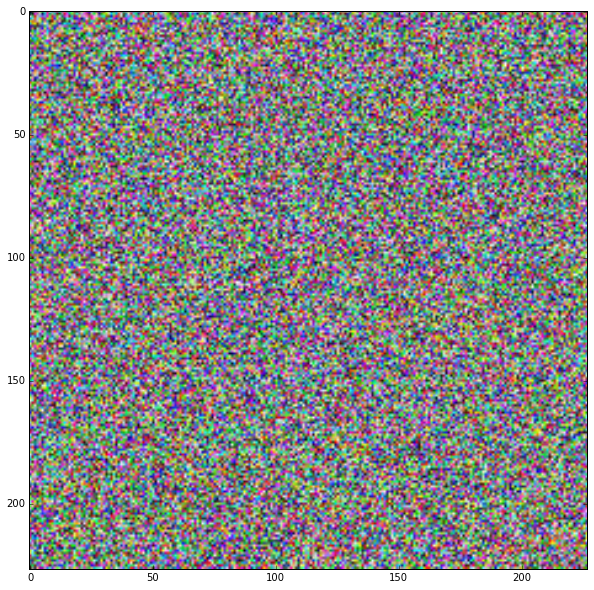

In [3]:
# pick a target class:
# target_label = 954 # banana
# target_label = 99 # goose
# target_label = 543 # dumbell
# target_label = 546 # electric guitar
# target_label = 282 # tiger cat
target_label = 281 # tabby cat

# start with a random image
current = np.random.rand(3,227,227)*255 - means[:,None,None]
act_hist = []

# learning rates -- play with these for different looking results
rate_smooth = .2
rate_obj = 1000
for it in range(1000):
    if it > 0 and it%100 == 0: print 'iteration {}'.format(it)
    # do a forward pass for the current version of the image
    # and collect the target activation to visualize later
    net.blobs['data'].data[...] = current
    act_hist.append(net.forward(end='fc8')['fc8'].flat[target_label])
    # set the topmost diff and do a backward pass back to the image
    # can also try: `np.arange(1000)==target_label`
    net.blobs['fc8'].diff[...].flat = 2*(np.arange(1000)==target_label)-1
    diff = net.backward(start='fc8')['data']
    # compute smoothness regularization
    x_diff = np.zeros_like(current)
    y_diff = np.zeros_like(current)
    if np.random.rand() > 0.5:
        y_diff[:,1:,:] = (current[:,1:,:] - current[:,:-1,:])
        x_diff[:,:,1:] = (current[:,:,1:] - current[:,:,:-1])
    else:
        y_diff[:,:-1,:] = (-current[:,1:,:] + current[:,:-1,:])
        x_diff[:,:,:-1] = (-current[:,:,1:] + current[:,:,:-1])
    # gradient descent step
    current = current + rate_obj*diff[0] - rate_smooth*x_diff - rate_smooth*y_diff


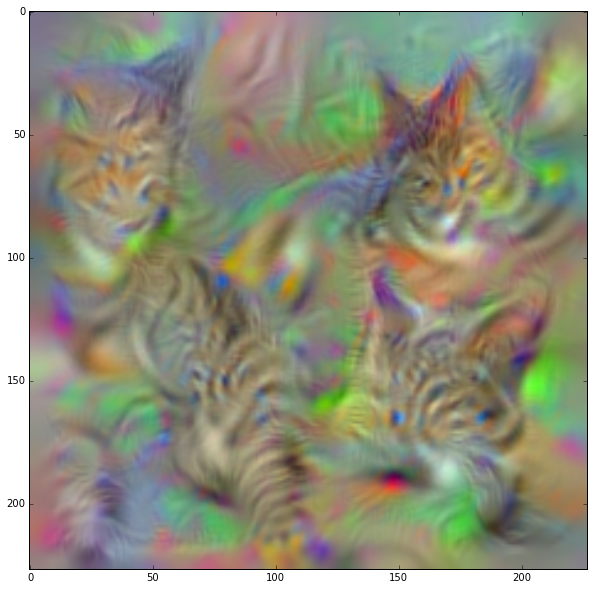

In [12]:
# show the picture
image = (current + means[:,None,None]).transpose(1,2,0)[:,:,[2,1,0]]
image = image - image.min()
image = image/image.max()
plt.imshow(image)

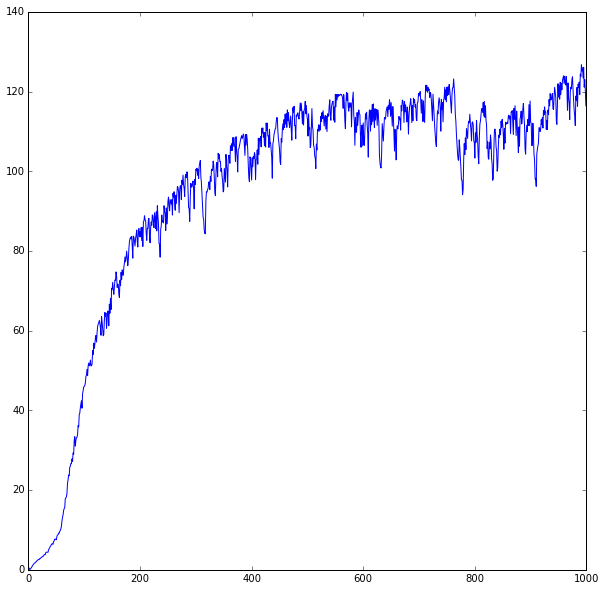

In [13]:
# plot the target activation throughout training
plt.plot(act_hist)

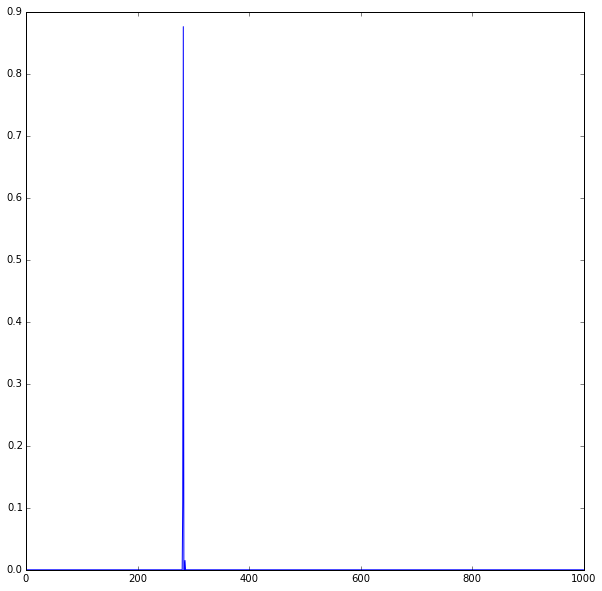

In [14]:
# plot class distribution
plt.plot(net.forward(end='prob')['prob'].flat)